In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cm
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings(action='ignore')

In [13]:
earthquake_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Earthquake_Damage.csv")
print(earthquake_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

In [14]:
#명목형 변수 제외하고 Scaling
from sklearn.preprocessing import StandardScaler

# 스케일링할 열 목록
scale_columns = [col for col in earthquake_df.columns if earthquake_df[col].dtype!='object' and col not in ['building_id', 'damage_grade']]

# 스케일러 초기화
scaler = StandardScaler()

# 스케일링 적용
earthquake_df[scale_columns] = scaler.fit_transform(earthquake_df[scale_columns])

print(earthquake_df.head())


   building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
0       802906       -0.983414       -0.518705        1.629055   
1        28830       -0.734459        0.481998       -0.945017   
2        94947        0.883744       -0.819158        0.744612   
3       590882        1.008221       -0.685893        1.216589   
4       201944       -0.361028       -1.381296       -1.308119   

   count_floors_pre_eq       age  area_percentage  height_percentage  \
0            -0.178274  0.047100        -0.459460          -0.226419   
1            -0.178274 -0.224765        -0.004110           0.816109   
2            -0.178274 -0.224765        -0.687135          -0.226419   
3            -0.178274 -0.224765        -0.459460          -0.226419   
4             1.195989  0.047100        -0.004110           1.858636   

  land_surface_condition foundation_type  ... has_secondary_use_hotel  \
0                      t               r  ...               -0.186537   
1                      o

In [15]:
from sklearn.preprocessing import OneHotEncoder

independent_vars=earthquake_df.drop(['building_id', 'damage_grade'], axis=1)
dependent_var=earthquake_df['damage_grade']

categorical_vars=independent_vars.select_dtypes(include=['object'])
ohe=OneHotEncoder(sparse_output=False) #밀집행렬로 생성
encoded_categorical_vars=pd.DataFrame(ohe.fit_transform(categorical_vars))
encoded_categorical_vars.columns=ohe.get_feature_names_out(categorical_vars.columns)
numerical_vars=independent_vars.select_dtypes(include=['int64', 'float64'])
encoded_vars=pd.concat([numerical_vars, encoded_categorical_vars, dependent_var], axis=1)

In [16]:
sampled_indicies=earthquake_df.sample(n=10000, random_state=42).index #10000개 추출

sampled_independent_vars=encoded_vars.drop('damage_grade', axis=1).loc[sampled_indicies]
sampled_dependent_var=encoded_vars.loc[sampled_indicies]['damage_grade']

x_train, x_temp, y_train, y_temp=train_test_split(sampled_independent_vars, sampled_dependent_var, test_size=6000, random_state=42)
x_val, x_test, y_val, y_test=train_test_split(x_temp, y_temp, test_size=2000, random_state=42)

In [17]:
#성능평가
from sklearn.metrics import accuracy_score

def calculate_matrix(y_true, y_pred):
  cm=confusion_matrix(y_true, y_pred)

  #Accuracy
  accuracy=accuracy_score(y_true, y_pred)

  #BCR
  BCRs=[]
  for i in range(cm.shape[0]):
    TP=cm[i,i]
    FN=cm[i,:].sum()-TP
    FP=cm[:,i].sum()-TP
    TN=cm.sum()-TP-FN-FP

    sensitivity=TP/(TP+FN) if TP+FN!=0 else 0
    specificity=TN/(TN+FP) if TN+FP!=0 else 0

    BCR=np.sqrt(sensitivity*specificity)
    BCRs.append(BCR)

  avg_BCR=np.mean(BCRs)

  return accuracy, avg_BCR

In [18]:
#각 모델의 초모수 후보값

#1.MLR
param_grid_logistic={'solver': ['lbfgs', 'sag'] ,'C': [0.1,1,100] ,'max_iter': [100, 200]}

#2. DT
param_grid_tree={'criterion': ['gini', 'entropy'] , 'max_depth': [None, 10, 20] , 'min_samples_split': [2, 10, 50]}

#ANN using MLPClassifier
param_grid_ann={'hidden_layer_sizes': [(50,), (100,)] ,'activation': ['relu', 'tanh', 'logistic'] , 'solver': ['adam', 'sgd', 'lbfgs'] , 'early_stopping':[True]}

In [19]:
#MLR 최적의 초모수 값 찾기
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid

logistic_model=LogisticRegression(multi_class='multinomial', random_state=42)
logistic_model.fit(x_train, y_train)

best_bcr=0.0
best_model_logi=None

for params in ParameterGrid(param_grid_logistic):
  model=LogisticRegression(**params, random_state=42)
  model.fit(x_train, y_train)
  y_val_pred=model.predict(x_val)

  accuracy, bcr=calculate_matrix(y_val, y_val_pred)

  if bcr>best_bcr:
    best_bcr=bcr
    best_model_logi=model

print("Best Model Hyperparameters", best_model_logi.get_params())

y_test_pred=best_model_logi.predict(x_test)
accuracy_logistic, bcr_logistic=calculate_matrix(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy_logistic:.5f}, Test BCR: {bcr_logistic:.5f}")

Best Model Hyperparameters {'C': 100, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Test Accuracy: 0.59100, Test BCR: 0.49911


In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.model_selection import ParameterGrid, cross_val_score

#DT 최적의 초모수 값 찾기
best_bcr=0.0
best_model_tree=None

for params in ParameterGrid(param_grid_tree):
  model=DecisionTreeClassifier(**params, random_state=42)
  model.fit(x_train, y_train)
  y_val_pred=model.predict(x_val)

  accuracy, bcr=calculate_matrix(y_val, y_val_pred)

  if bcr>best_bcr:
    best_bcr=bcr
    best_model_tree=model

print("Best Model Hyperparameters", best_model_tree.get_params())

y_test_pred=best_model_tree.predict(x_test)
accuracy_tree, bcr_tree=calculate_matrix(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy_tree:.5f}, Test BCR: {bcr_tree:.5f}")

Best Model Hyperparameters {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
Test Accuracy: 0.56500, Test BCR: 0.59721


In [21]:
from tqdm import tqdm

#ANN 최적의 초모수 값 찾기
best_bcr=0.0
best_model_ann=None

total_iterations=len(ParameterGrid(param_grid_ann))
pbar=tqdm(total=total_iterations, desc="Running iterations", unit="iteration")

for params in ParameterGrid(param_grid_ann):
  model=MLPClassifier(**params, random_state=42)
  model.fit(x_train, y_train)
  y_val_pred=model.predict(x_val)

  accuracy, bcr=calculate_matrix(y_val, y_val_pred)

  if bcr>best_bcr:
    best_bcr=bcr
    best_model_ann=model

pbar.close()

print("Best Model Hyperparameters", best_model_ann.get_params())

y_test_pred=best_model_ann.predict(x_test)
accuracy_ann, bcr_ann=calculate_matrix(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy_ann:.5f}, Test BCR: {bcr_ann:.5f}")

Running iterations:   0%|          | 0/18 [00:42<?, ?iteration/s]

Best Model Hyperparameters {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'lbfgs', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Test Accuracy: 0.54400, Test BCR: 0.57036


In [40]:
# Baggin Training
bootstrap_nums = [10, 30, 50, 100, 200, 300]

best_bcr=0.0
best_bootstrap_num = None
best_bagging_tree=None

for bootstrap_num in bootstrap_nums:
  bagging_tree_model = BaggingClassifier(base_estimator = best_model_tree, n_estimators = bootstrap_num, n_jobs = 8,bootstrap = True,verbose = 1, random_state=42).fit(x_train, y_train)
  y_val_pred=bagging_tree_model.predict(x_val)

  accuracy, bcr=calculate_matrix(y_val, y_val_pred)
  print(f"Bootstrap num: {bootstrap_num} - Accuracy: {accuracy:.5f}, BCR: {bcr:.5f}")

  if bcr>best_bcr:
      best_bcr=bcr
      best_bootstrap_num = bootstrap_num
      best_bagging_tree=bagging_tree_model

y_test_pred=best_bagging_tree.predict(x_test)
accuracy_bagging_tree, bcr_bagging_tree=calculate_matrix(y_test, y_test_pred)
print(f'Best Bootstrap num: {best_bootstrap_num} Test Accuracy:{accuracy_bagging_tree:.5f} Test BCR: {bcr_bagging_tree:.5f}')

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.7s remaining:   20.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   10.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Bootstrap num: 10 - Accuracy: 0.65275, BCR: 0.62530


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.3s remaining:    3.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


Bootstrap num: 30 - Accuracy: 0.66450, BCR: 0.62877


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.2s remaining:    3.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Bootstrap num: 50 - Accuracy: 0.67125, BCR: 0.62780


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.1s remaining:    6.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished


Bootstrap num: 100 - Accuracy: 0.67250, BCR: 0.62989


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    4.9s remaining:   14.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Bootstrap num: 200 - Accuracy: 0.67075, BCR: 0.62269


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    9.0s remaining:   27.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   12.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Bootstrap num: 300 - Accuracy: 0.66975, BCR: 0.62380


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


Best Bootstrap num: 100 Test Accuracy:0.65200 Test BCR: 0.61657


In [41]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

# Tree의 수 설정
tree_nums= [10, 30, 50, 100, 200, 300]

# 최적의 결과를 저장할 변수 초기화
best_bcr = 0.0
best_n_estimators = None
best_random_forest = None

for n_estimators in tree_nums:
    # 랜덤 포레스트 모델 생성
    random_forest_model = RandomForestClassifier(n_estimators=n_estimators, random_state=22)

    # 모델 학습
    random_forest_model.fit(x_train, y_train)

    # 검증 데이터셋을 사용하여 예측
    y_val_pred = random_forest_model.predict(x_val)

    # 분류 성능 지표 산출
    accuracy, bcr=calculate_matrix(y_val, y_val_pred)

    # 결과 출력
    print(f"Number of Trees: {n_estimators} - Accuracy: {accuracy:.5f}, BCR: {bcr:.5f}")

    # 최적의 결과 업데이트
    if bcr > best_bcr:
        best_bcr = bcr
        best_n_estimators = n_estimators
        best_random_forest = random_forest_model

# 최적의 모델을 사용하여 테스트 데이터셋 평가
y_test_pred = best_random_forest.predict(x_test)
accuracy_rf, bcr_rf= calculate_matrix(y_test, y_test_pred)
print(f'Best Number of Trees: {best_n_estimators} Test Accuracy:{accuracy_rf:.5f} Test BCR: {bcr_rf:.5f}')

Number of Trees: 10 - Accuracy: 0.63200, BCR: 0.59885
Number of Trees: 30 - Accuracy: 0.65075, BCR: 0.59929
Number of Trees: 50 - Accuracy: 0.65525, BCR: 0.59986
Number of Trees: 100 - Accuracy: 0.66375, BCR: 0.59931
Number of Trees: 200 - Accuracy: 0.65975, BCR: 0.59666
Number of Trees: 300 - Accuracy: 0.66025, BCR: 0.59887
Best Number of Trees: 50 Test Accuracy:0.64500 Test BCR: 0.58483


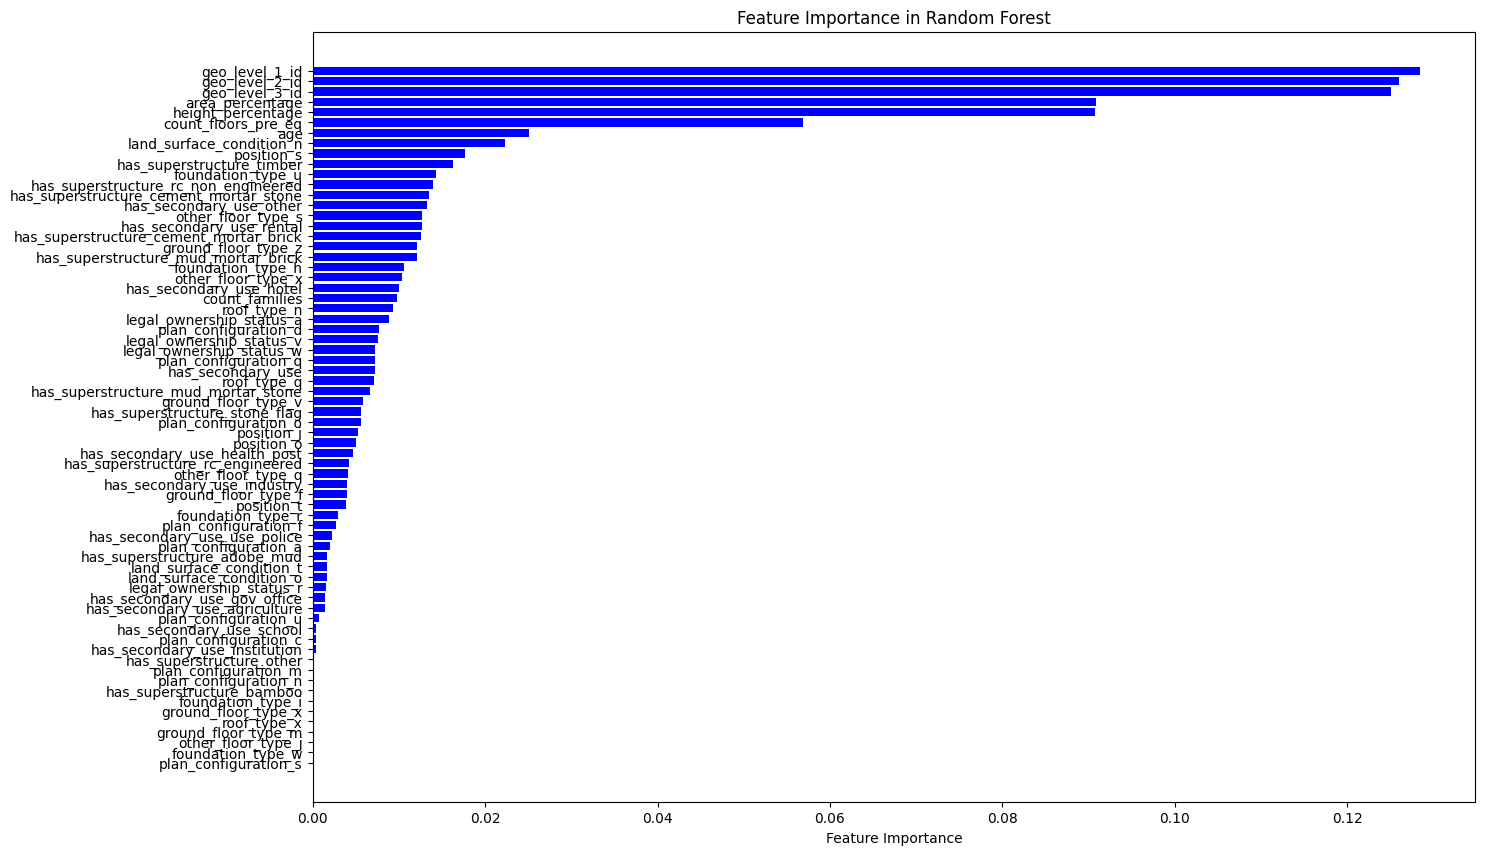

In [24]:
#최적의 모델에 대한 변수 중요도
# 변수 중요도 산출
feature_importances = best_random_forest.feature_importances_

# 컬럼명 사용하여 특성 이름 설정
feature_names = x_train.columns

# 변수 중요도를 기준으로 내림차순 정렬
indices = np.argsort(feature_importances)[::-1]

# 특성 이름 설정
feature_names = [feature_names[i] for i in indices]

# 중요도와 이름을 매칭
sorted_feature_names = [feature_names[i] for i in indices]
sorted_feature_importances = feature_importances[indices]

# 변수 중요도 막대 그래프 그리기
plt.figure(figsize=(15, 10))
plt.barh(sorted_feature_names, sorted_feature_importances, color='blue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
plt.show()

In [25]:
# 변수 중요도를 포함한 표 작성
importance_df=pd.DataFrame({'Feature Name': sorted_feature_names, 'Feature importance': sorted_feature_importances})

print(importance_df)

            Feature Name  Feature importance
0         geo_level_1_id            0.128396
1         geo_level_2_id            0.125961
2         geo_level_3_id            0.125015
3        area_percentage            0.090794
4      height_percentage            0.090759
..                   ...                 ...
63           roof_type_x            0.000043
64   ground_floor_type_m            0.000015
65    other_floor_type_j            0.000000
66     foundation_type_w            0.000000
67  plan_configuration_s            0.000000

[68 rows x 2 columns]


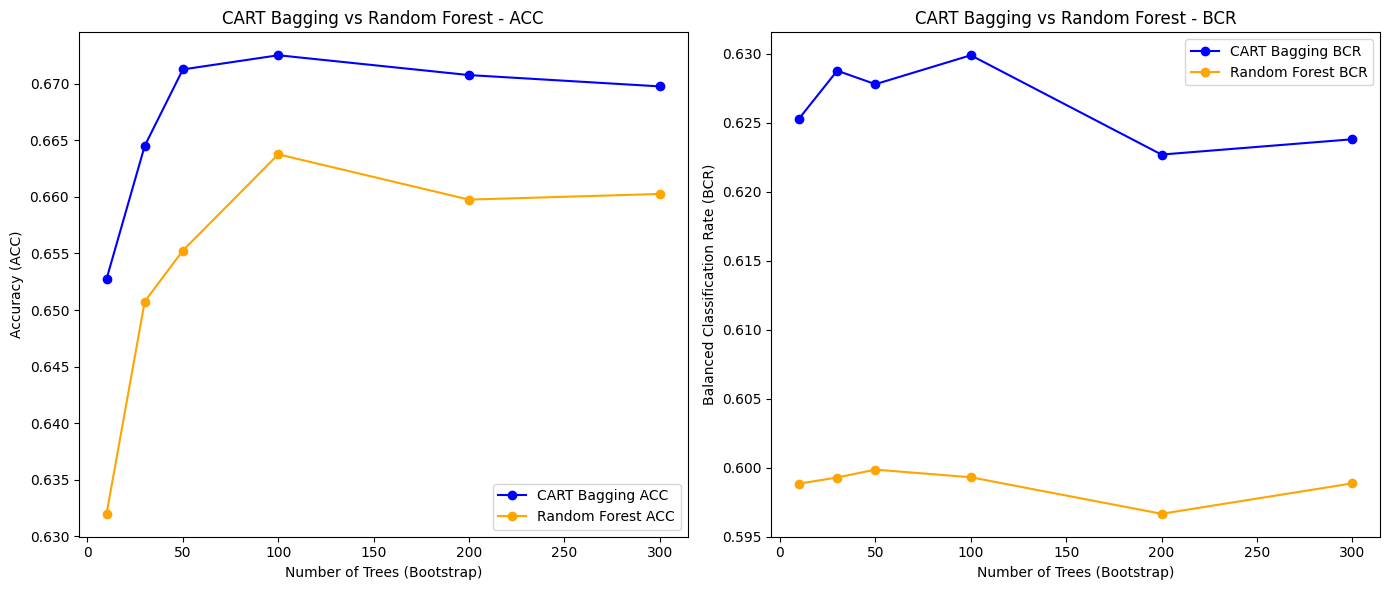

In [26]:
# 부트스트랩 수 설정
bootstrap_nums = [10, 30, 50, 100, 200, 300]

# 결과 저장을 위한 리스트 초기화
cart_bagging_acc = []
cart_bagging_bcr = []
random_forest_acc = []
random_forest_bcr = []

for bootstrap_num in bootstrap_nums:
    # CART Bagging 모델 학습 및 평가
    bagging_tree_model = BaggingClassifier(base_estimator=best_model_tree, n_estimators=bootstrap_num, n_jobs=8, bootstrap=True, random_state=42).fit(x_train, y_train)
    y_val_pred_bagging = bagging_tree_model.predict(x_val)
    accuracy_bagging, bcr_bagging = calculate_matrix(y_val, y_val_pred_bagging)
    cart_bagging_acc.append(accuracy_bagging)
    cart_bagging_bcr.append(bcr_bagging)

    # Random Forest 모델 학습 및 평가
    random_forest_model = RandomForestClassifier(n_estimators=bootstrap_num, random_state=22).fit(x_train, y_train)
    y_val_pred_rf = random_forest_model.predict(x_val)
    accuracy_rf, bcr_rf = calculate_matrix(y_val, y_val_pred_rf)
    random_forest_acc.append(accuracy_rf)
    random_forest_bcr.append(bcr_rf)

# 그래프 그리기
plt.figure(figsize=(14, 6))

# ACC 비교 그래프
plt.subplot(1, 2, 1)
plt.plot(bootstrap_nums, cart_bagging_acc, label='CART Bagging ACC', color='blue', marker='o')
plt.plot(bootstrap_nums, random_forest_acc, label='Random Forest ACC', color='orange', marker='o')
plt.xlabel('Number of Trees (Bootstrap)')
plt.ylabel('Accuracy (ACC)')
plt.title('CART Bagging vs Random Forest - ACC')
plt.legend()

# BCR 비교 그래프
plt.subplot(1, 2, 2)
plt.plot(bootstrap_nums, cart_bagging_bcr, label='CART Bagging BCR', color='blue', marker='o')
plt.plot(bootstrap_nums, random_forest_bcr, label='Random Forest BCR', color='orange', marker='o')
plt.xlabel('Number of Trees (Bootstrap)')
plt.ylabel('Balanced Classification Rate (BCR)')
plt.title('CART Bagging vs Random Forest - BCR')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
num_iterations=10
accuracies=[]
bcrs=[]

# random_state를 제외한 모델의 매개변수 가져오기
best_model_ann_params = best_model_ann.get_params()
del best_model_ann_params['random_state']

for _ in tqdm(range(num_iterations), desc='Running iterations', unit='iterations'):
   # ANN 모델 생성 및 학습
    model = MLPClassifier(**best_model_ann_params)
    model.fit(x_train, y_train)

    y_test_pred=model.predict(x_test)

    accuracy, bcr=calculate_matrix(y_test, y_test_pred)

    accuracies.append(accuracy)
    bcrs.append(bcr)

# 결과 출력
print(f"Mean Test Accuracy: {np.mean(accuracies):.5f} (±{np.std(accuracies):.5f})")
print(f"Mean Test BCR: {np.mean(bcrs):.5f} (±{np.std(bcrs):.5f})")

Running iterations: 100%|██████████| 10/10 [00:29<00:00,  2.96s/iterations]

Mean Test Accuracy: 0.54890 (±0.00930)
Mean Test BCR: 0.55959 (±0.01031)


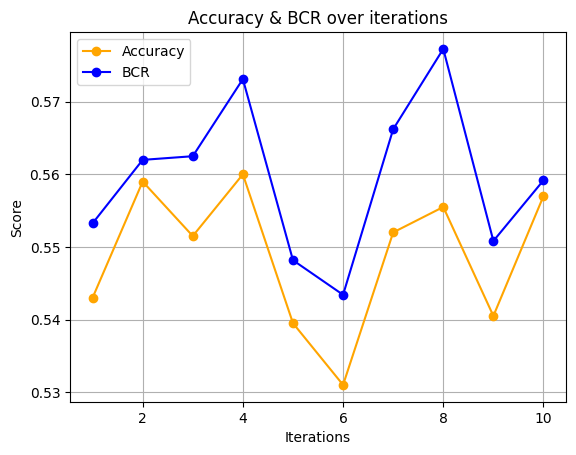

In [28]:
#결과 시각화
plt.plot(range(1, len(accuracies)+1), accuracies, marker='o', label='Accuracy', color='orange')
plt.plot(range(1, len(bcrs)+1), bcrs, marker='o', label='BCR', color='blue')
plt.xlabel('Iterations')
plt.ylabel('Score')
plt.title('Accuracy & BCR over iterations')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Baggin Training
bootstrap_nums = [10, 30, 50, 100, 200, 300]

best_bcr = 0.0
best_bootstrap_num = None
best_bagging_ann = None

for bootstrap_num in bootstrap_nums:
        # Bagging 모델 생성 및 학습
    bagging_ann_model = BaggingClassifier(base_estimator=best_model_ann, n_estimators=bootstrap_num,
                                              n_jobs=8, bootstrap=True, verbose=1, random_state=42).fit(x_train, y_train)
    y_val_pred = bagging_ann_model.predict(x_val)

    accuracy, bcr = calculate_matrix(y_val, y_val_pred)

    print(f"Bootstrap num: {bootstrap_num} - Accuracy: {accuracy:.5f} BCR: {bcr:.5f} ")

    if bcr > best_bcr:
      best_bcr = bcr
      best_bootstrap_num = bootstrap_num
      best_bagging_ann = bagging_ann_model

y_test_pred = best_bagging_ann.predict(x_test)
accuracy_bagging_ann, bcr_bagging_ann = calculate_matrix(y_test, y_test_pred)
print(f'Best Bootstrap num: {best_bootstrap_num} Test Accuracy: {accuracy_bagging_ann:.5f} Test BCR: {bcr_bagging_ann:.5f}')


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   10.5s remaining:   31.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   15.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Bootstrap num: 10 - Accuracy: 0.58850 BCR: 0.58468 


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   47.2s remaining:  2.4min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   51.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Bootstrap num: 30 - Accuracy: 0.60025 BCR: 0.58328 


In [35]:
#CART ADABOOST 최적의 초모수 값 찾기
best_bcr = 0.0
best_ada_cart = None
param_grid_ada_cart = {'learning_rate': [1, 0.1, 0.01, 0.001], 'n_estimators': [50, 100, 150, 200]}

total_iterations = len(ParameterGrid(param_grid_ada_cart))
pbar = tqdm(total=total_iterations, desc="Running iterations", unit="iteration")

for params in ParameterGrid(param_grid_ada_cart):
    model = AdaBoostClassifier(base_estimator=best_model_tree, learning_rate=params['learning_rate'], n_estimators=params['n_estimators'], random_state=42)
    model.fit(x_train, y_train)
    y_val_pred = model.predict(x_val)

    accuracy, bcr = calculate_matrix(y_val, y_val_pred)

    if bcr > best_bcr:
        best_bcr = bcr
        best_ada_cart = model

    pbar.update(1)

pbar.close()

print("Best Model Hyperparameters:", best_ada_cart.get_params())

y_test_pred = best_ada_cart.predict(x_test)
accuracy_adacart, bcr_adacart = calculate_matrix(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy_adacart:.5f}, Test BCR: {bcr_adacart:.5f}")

Running iterations: 100%|██████████| 16/16 [01:54<00:00,  7.17s/iteration]


Best Model Hyperparameters: {'algorithm': 'SAMME.R', 'base_estimator__ccp_alpha': 0.0, 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': None, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 10, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__random_state': 42, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeClassifier(min_samples_split=10, random_state=42), 'estimator': None, 'learning_rate': 0.001, 'n_estimators': 200, 'random_state': 42}
Test Accuracy: 0.63850, Test BCR: 0.61113


In [36]:
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingClassifier
#CART GBM 최적의 초모수 값 찾기
best_bcr = 0.0
best_gbm_cart = None
param_grid_gbm_cart={'n_estimators': [30, 50, 70] ,'subsample': [0.5, 0.7, 0.9] ,'loss': ['deviance', 'log_loss']}

total_iterations = len(ParameterGrid(param_grid_gbm_cart))
pbar = tqdm(total=total_iterations, desc="Running iterations", unit="iteration")

for params in ParameterGrid(param_grid_gbm_cart):
    model = GradientBoostingClassifier(n_estimators=params['n_estimators'],
        subsample=params['subsample'],
        loss=params['loss'],
        random_state=42)
    model.fit(x_train, y_train)
    y_val_pred = model.predict(x_val)

    accuracy, bcr = calculate_matrix(y_val, y_val_pred)

    if bcr > best_bcr:
        best_bcr = bcr
        best_gbm_cart = model

    pbar.update(1)

pbar.close()

print("Best Model Hyperparameters:", best_gbm_cart.get_params())

y_test_pred = best_gbm_cart.predict(x_test)
accuracy_gbmcart, bcr_gbmcart = calculate_matrix(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy_gbmcart:.5f}, Test BCR: {bcr_gbmcart:.5f}")

Running iterations: 100%|██████████| 18/18 [00:24<00:00,  1.34s/iteration]

Best Model Hyperparameters: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 70, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.5, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Test Accuracy: 0.66750, Test BCR: 0.59948


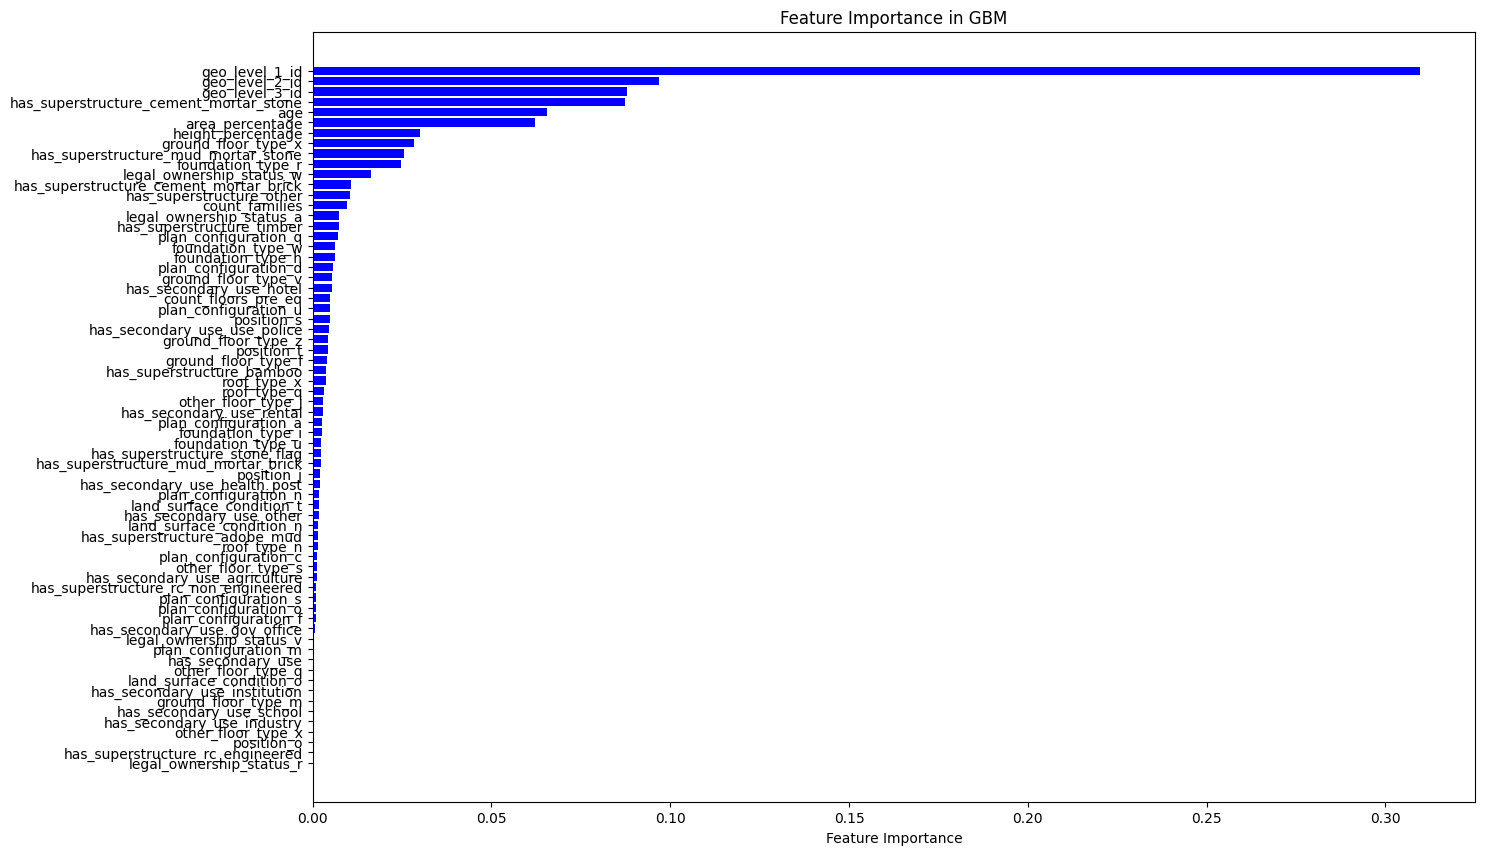

In [37]:
# 변수 중요도 산출
feature_importances = best_gbm_cart.feature_importances_

# 컬럼명 사용하여 특성 이름 설정
feature_names = x_train.columns

# 변수 중요도를 기준으로 내림차순 정렬
indices = np.argsort(feature_importances)[::-1]

# 특성 이름 설정
feature_names = [feature_names[i] for i in indices]

# 중요도와 이름을 매칭
sorted_feature_names = [feature_names[i] for i in indices]
sorted_feature_importances = feature_importances[indices]

# 변수 중요도 막대 그래프 그리기
plt.figure(figsize=(15, 10))
plt.barh(sorted_feature_names, sorted_feature_importances, color='blue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in GBM')
plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
plt.show()


In [38]:
importance_df=pd.DataFrame({'Feature Name': sorted_feature_names, 'Feature importances': sorted_feature_importances})
print(importance_df)

                              Feature Name  Feature importances
0                           geo_level_1_id             0.309602
1                           geo_level_2_id             0.096736
2                           geo_level_3_id             0.087952
3   has_superstructure_cement_mortar_stone             0.087483
4                                      age             0.065684
..                                     ...                  ...
63              has_secondary_use_industry             0.000000
64                      other_floor_type_x             0.000000
65                              position_o             0.000000
66        has_superstructure_rc_engineered             0.000000
67                legal_ownership_status_r             0.000000

[68 rows x 2 columns]


In [39]:
#Extra
from imblearn.under_sampling import RandomUnderSampler
# 언더샘플링 적용
undersampler = RandomUnderSampler(random_state=42)
x_train_under, y_train_under = undersampler.fit_resample(x_train, y_train)

# Bagging Training
bootstrap_nums = [10, 30, 50, 100, 200, 300]
best_bcr = 0.0
best_bootstrap_num = None
best_bagging_tree = None


for bootstrap_num in bootstrap_nums:
    bagging_tree_model = BaggingClassifier(base_estimator=best_model_tree, n_estimators=bootstrap_num, n_jobs=8, bootstrap=True, verbose=1, random_state=42).fit(x_train_under, y_train_under)
    y_val_pred = bagging_tree_model.predict(x_val)

    accuracy, bcr = calculate_matrix(y_val, y_val_pred)
    print(f"Bootstrap num: {bootstrap_num} - Accuracy: {accuracy:.5f}, BCR: {bcr:.5f}")

    if bcr > best_bcr:
        best_bcr = bcr
        best_bootstrap_num = bootstrap_num
        best_bagging_tree = bagging_tree_model

y_test_pred = best_bagging_tree.predict(x_test)
accuracy_bagging_tree, bcr_bagging_tree = calculate_matrix(y_test, y_test_pred)
print(f'Best Bootstrap num: {best_bootstrap_num} Test Accuracy: {accuracy_bagging_tree:.5f} Test BCR: {bcr_bagging_tree:.5f}')


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    5.5s remaining:   16.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Bootstrap num: 10 - Accuracy: 0.55575, BCR: 0.68212


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


Bootstrap num: 30 - Accuracy: 0.56075, BCR: 0.69008


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Bootstrap num: 50 - Accuracy: 0.56900, BCR: 0.69575


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


Bootstrap num: 100 - Accuracy: 0.57700, BCR: 0.70122


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.8s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Bootstrap num: 200 - Accuracy: 0.57800, BCR: 0.69953


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.2s remaining:    3.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished


Bootstrap num: 300 - Accuracy: 0.57600, BCR: 0.69803


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


Best Bootstrap num: 100 Test Accuracy: 0.55350 Test BCR: 0.68159
